# Load the daily updated dataset

In [1]:
# Azure storage access info
blob_account_name = "pandemicdatalake"
blob_container_name = "public"
blob_relative_path = "curated/covid-19/ecdc_cases/latest/ecdc_cases.parquet"
blob_sas_token = r""

# Allow SPARK to read from Blob remotely
wasbs_path = 'wasbs://%s@%s.blob.core.windows.net/%s' % (blob_container_name, blob_account_name, blob_relative_path)
spark.conf.set(
  'fs.azure.sas.%s.%s.blob.core.windows.net' % (blob_container_name, blob_account_name),
  blob_sas_token)
print('Remote blob path: ' + wasbs_path)

# SPARK read parquet, note that it won't load any data yet by now
df = spark.read.parquet(wasbs_path)
print('Register the DataFrame as a SQL temporary view: source')
df.createOrReplaceTempView('source')

# Display top 10 rows
print('Displaying top 10 rows: ')
display(spark.sql('SELECT * FROM source LIMIT 10'))

StatementMeta(smallPool, 15, 1, Finished, Available)

Remote blob path: wasbs://public@pandemicdatalake.blob.core.windows.net/curated/covid-19/ecdc_cases/latest/ecdc_cases.parquet
Register the DataFrame as a SQL temporary view: source
Displaying top 10 rows: 


SynapseWidget(Synapse.DataFrame, 0739a730-0ffb-4605-bd51-06667fd2e4cf)

In [2]:
spark.sql('SELECT * FROM source order by date_rep desc LIMIT 10').show(vertical=True)

StatementMeta(smallPool, 15, 2, Finished, Available)

-RECORD 0-----------------------------------------
 date_rep                  | 2020-12-14           
 day                       | 14                   
 month                     | 12                   
 year                      | 2020                 
 cases                     | 0                    
 deaths                    | 0                    
 countries_and_territories | Anguilla             
 geo_id                    | AI                   
 country_territory_code    | AIA                  
 pop_data_2018             | null                 
 continent_exp             | America              
 load_date                 | 2021-07-15 00:06:... 
 iso_country               | AI                   
-RECORD 1-----------------------------------------
 date_rep                  | 2020-12-14           
 day                       | 14                   
 month                     | 12                   
 year                      | 2020                 
 cases                     | 17

In [3]:
df.count()

StatementMeta(smallPool, 15, 3, Finished, Available)

61900

61900 records in total in our updated dataset and the load date is 6th of July in this case

# Existing Datalake (dataset uploaded on the 22nd of June 2021)


Previously loaded the parquet file in a storage from https://pandemicdatalake.blob.core.windows.net/public/curated/covid-19/ecdc_cases/latest/ecdc_cases.parquet

Setup the path location where the parquet file is stored

In [4]:
storagePath = "abfss://churning@churninge2edemo.dfs.core.windows.net/synapse/tables/covid"

StatementMeta(smallPool, 15, 4, Finished, Available)

In [5]:
dfcovidParquet = spark.read.load(f"{storagePath}/ecdc_cases.parquet", format="parquet")

StatementMeta(smallPool, 15, 5, Finished, Available)

# Convert the parquet file to delta

In [6]:
dfcovidParquet.write.format("delta").mode("overwrite").save(f"{storagePath}/delta")

StatementMeta(smallPool, 15, 6, Finished, Available)

In [7]:
dfCovidDelta =  spark.read.load(f"{storagePath}/delta", format="delta")

StatementMeta(smallPool, 15, 7, Finished, Available)

In [23]:
dfSubsetDataSet = dfCovidDelta.where("date_rep <= '2020-10-10'")

StatementMeta(smallPool, 15, 23, Finished, Available)

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

StatementMeta(smallPool, 15, 30, Finished, Available)

In [31]:
dfSubsetDataSetPandas = dfSubsetDataSet.toPandas()

StatementMeta(smallPool, 15, 31, Finished, Available)

StatementMeta(smallPool, 15, 32, Finished, Available)

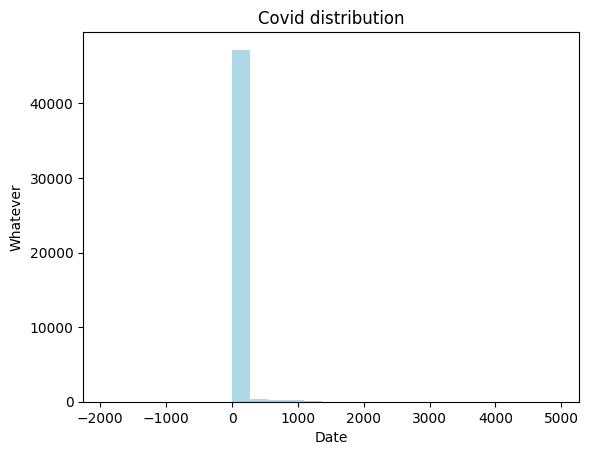

In [32]:
# Look at a histogram of tips by count by using Matplotlib

ax1 = dfSubsetDataSetPandas['deaths'].plot(kind='hist', bins=25, facecolor='lightblue')
ax1.set_title('Covid distribution')
ax1.set_xlabel('Date')
ax1.set_ylabel('Whatever')
plt.suptitle('')
plt.show()

In [24]:
display(dfSubsetDataSet)

StatementMeta(smallPool, 15, 24, Finished, Available)

SynapseWidget(Synapse.DataFrame, d4db65cb-e430-46b3-a3b9-f09090deb941)

In [8]:
dfCovidDelta.show(vertical=True)

StatementMeta(smallPool, 15, 8, Finished, Available)

-RECORD 0-----------------------------------------
 date_rep                  | 2020-12-14           
 day                       | 14                   
 month                     | 12                   
 year                      | 2020                 
 cases                     | 746                  
 deaths                    | 6                    
 countries_and_territories | Afghanistan          
 geo_id                    | AF                   
 country_territory_code    | AFG                  
 pop_data_2018             | null                 
 continent_exp             | Asia                 
 load_date                 | 2021-06-22 00:05:... 
 iso_country               | AF                   
-RECORD 1-----------------------------------------
 date_rep                  | 2020-12-13           
 day                       | 13                   
 month                     | 12                   
 year                      | 2020                 
 cases                     | 29

In [9]:
dfCovidDelta.count()

StatementMeta(smallPool, 15, 9, Finished, Available)

61900

61900 records in total in our datalake

We have now 2 Datasets:
<br> One from the 22nd of June: **dfCovidDelta**
<br> One based on the daily updated: **df**

# Check any difference between these two datasets in term of cases and deaths for the same country and date

In [10]:
dfDiff = dfCovidDelta.join(df,(dfCovidDelta.date_rep ==  df.date_rep) & (dfCovidDelta.iso_country == df.iso_country) & ((dfCovidDelta.cases !=  df.cases) | (dfCovidDelta.deaths !=  df.deaths))).select("*")

StatementMeta(smallPool, 15, 10, Finished, Available)

In [11]:
dfDiff.show(vertical=True)

StatementMeta(smallPool, 15, 11, Finished, Available)

(0 rows)

There is no differences in term of cases, detahs for the same country
<br> The dataset contains only data until 14/12/2020. See https://www.ecdc.europa.eu/en/covid-19/data-collection
<br> The only difference is the load date

# Create a Delta table from DataLake location

In [12]:
from delta.tables import *

deltaCovidTable = DeltaTable.forPath(spark,f"{storagePath}/delta")

StatementMeta(smallPool, 15, 12, Finished, Available)

In [13]:
from pyspark.sql.functions import to_date, col

StatementMeta(smallPool, 15, 13, Finished, Available)

In [14]:
deltaCovidTable.toDF().withColumn("load_date_dateFormat",to_date(col("load_date"),"yyyy-MM-dd")).show(vertical=True)

StatementMeta(smallPool, 15, 14, Finished, Available)

-RECORD 0-----------------------------------------
 date_rep                  | 2020-12-14           
 day                       | 14                   
 month                     | 12                   
 year                      | 2020                 
 cases                     | 746                  
 deaths                    | 6                    
 countries_and_territories | Afghanistan          
 geo_id                    | AF                   
 country_territory_code    | AFG                  
 pop_data_2018             | null                 
 continent_exp             | Asia                 
 load_date                 | 2021-06-22 00:05:... 
 iso_country               | AF                   
 load_date_dateFormat      | 2021-06-22           
-RECORD 1-----------------------------------------
 date_rep                  | 2020-12-13           
 day                       | 13                   
 month                     | 12                   
 year                      | 20

# Merge the two datasets to keep in our datalake only the the most updated records

In [15]:

deltaCovidTable.alias("deltaLake").merge(df.alias("dataUpdate"),condition="deltaLake.date_rep = dataUpdate.date_rep and deltaLake.iso_country = dataUpdate.iso_country").whenMatchedUpdate(set = {"cases":"dataUpdate.cases","load_date": "dataUpdate.load_date"}).execute()


StatementMeta(smallPool, 15, 15, Finished, Available)

# Check if after the merge we have still data loaded on the 22nd of June

In [16]:
deltaCovidTable.toDF().withColumn("load_date_dateFormat",to_date(col("load_date"),"yyyy-MM-dd")).where("load_date_dateFormat = '2021-06-22'").show(vertical=True)

StatementMeta(smallPool, 15, 16, Finished, Available)

(0 rows)

# Check if after the merge we have data from the last updates

In [17]:
deltaCovidTable.toDF().withColumn("load_date_dateFormat",to_date(col("load_date"),"yyyy-MM-dd")).where("load_date_dateFormat = '2021-07-06'").show(vertical=True)

StatementMeta(smallPool, 15, 17, Finished, Available)

(0 rows)

In [18]:
deltaCovidTable.toDF().count()

StatementMeta(smallPool, 15, 18, Finished, Available)

61900

After the merge our dataset still contain 61900 records...but only from the most updated dataset